In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
import struct
import h5py
import pickle as pkl
import bluepyopt as bpop
import nrnUtils
from neuron import h




def nrnMread(fileName):
    f = open(fileName, "rb")
    nparam = struct.unpack('i', f.read(4))[0]
    typeFlg = struct.unpack('i', f.read(4))[0]
    return np.fromfile(f,np.double)

data_dir ='../Data'


def nrnMreadH5(fileName):
    f = h5py.File(fileName,'r')
    dat = f['Data'][:][0]
    return np.array(dat)

In [2]:

with open("/global/cscratch1/sd/zladd/axonstandardized/playground/gen_alg_GPU/python/best_indv_logs/best_indvs_gen_48.pkl", 'rb') \
as f:
    best_ind = pkl.load(f)
best_params = np.array(best_ind[47]) # 48 of these

In [3]:
paramsCSV = '../params/params_bbp_full.csv'
#orig_params = np.array(np.array(nrnUtils.readParamsCSV(paramsCSV))[:,1], dtype=np.float64)
orig_params = h5py.File('../params/params_bbp_full.hdf5', 'r')['orig_full'][0]
print(orig_params.shape)
scores_path = '../scores/'
objectives_file = h5py.File('../objectives/multi_stim_bbp_full.hdf5', 'r')
opt_weight_list = objectives_file['opt_weight_list'][:]
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
opt_stim_list = [e.decode('ascii') for e in opt_stim_name_list]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
stims_path = '../stims/stims_full.hdf5'
stim_file = h5py.File(stims_path, 'r')
#target_volts_path = './target_volts/allen_data_target_volts_10000.hdf5'
#target_volts_hdf5 = h5py.File(target_volts_path, 'r')
#params_opt_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
params_opt_ind = np.arange(24) 
model_dir = '..'
data_dir = model_dir+'/Data/'
run_dir = '../bin'
vs_fn = '/tmp/Data/VHotP'
data = nrnUtils.readParamsCSV(paramsCSV)
#self.opt_ind = params_opt_ind
data = np.array([data[i] for i in params_opt_ind])
pmin = np.array((data[:,2]), dtype=np.float64)
pmax = np.array((data[:,3]), dtype=np.float64)
# make this a function
fixed = {}
params = []
for param_idx in range(len(orig_params)):
    if np.isclose(orig_params[param_idx],pmin[param_idx],rtol=.001) and np.isclose(pmin[param_idx],pmax[param_idx],rtol=.001):
        print(orig_params[param_idx], " idx : ", param_idx)
        fixed[param_idx] = orig_params[param_idx]
    else:
        params.append(bpop.parameters.Parameter(orig_params[param_idx], bounds=(pmin[param_idx],pmax[param_idx])))

(24,)
8e-05  idx :  0
0.00291  idx :  7
287.198731  idx :  13
0.000609  idx :  15
210.485284  idx :  21


In [4]:
for reinsert_idx in fixed.keys():
    best_params = np.insert(np.array(best_params), reinsert_idx, fixed[reinsert_idx], axis = 0)

In [5]:
#os.getcwd()
os.chdir("../../genetic_alg2")

# NEURON run model using params obtained from GPU BestInds

In [8]:
run_file = './run_model_cori.hoc'
run_volts_path = '../run_volts_bbp_full_gpu_tuned/'
paramsCSV = run_volts_path+'params/params_bbp_full_gpu_tuned_10_based.csv'
scores_path = '../scores/'
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
stims_path = run_volts_path+'/stims/allen_data_stims_10000.hdf5'

custom_score_functions = [
                    'chi_square_normal',\
                    'traj_score_1',\
                    'traj_score_2',\
                    'traj_score_3',\
                    'isi',\
                    'rev_dot_product',\
                    'KL_divergence']

# Number of timesteps for the output volt.
ntimestep = 10000

def run_model(param_set, stim_name_list):
    h.load_file(run_file)
    volts_list = []
    for elem in stim_name_list:
        stims_hdf5 = h5py.File(stims_path, 'r')
        curr_stim = stims_hdf5[elem][:]
        total_params_num = len(param_set)
        dt = stims_hdf5[elem+'_dt']
        timestamps = np.array([dt for i in range(ntimestep)])
        h.curr_stim = h.Vector().from_python(curr_stim)
        h.transvec = h.Vector(total_params_num, 1).from_python(param_set)
        h.stimtime = h.Matrix(1, len(timestamps)).from_vector(h.Vector().from_python(timestamps))
        h.ntimestep = ntimestep
        h.runStim()
        out = h.vecOut.to_python()        
        volts_list.append(out)
    return np.array(volts_list)

In [ ]:
data_volts_list = run_model(best_params, opt_stim_list)

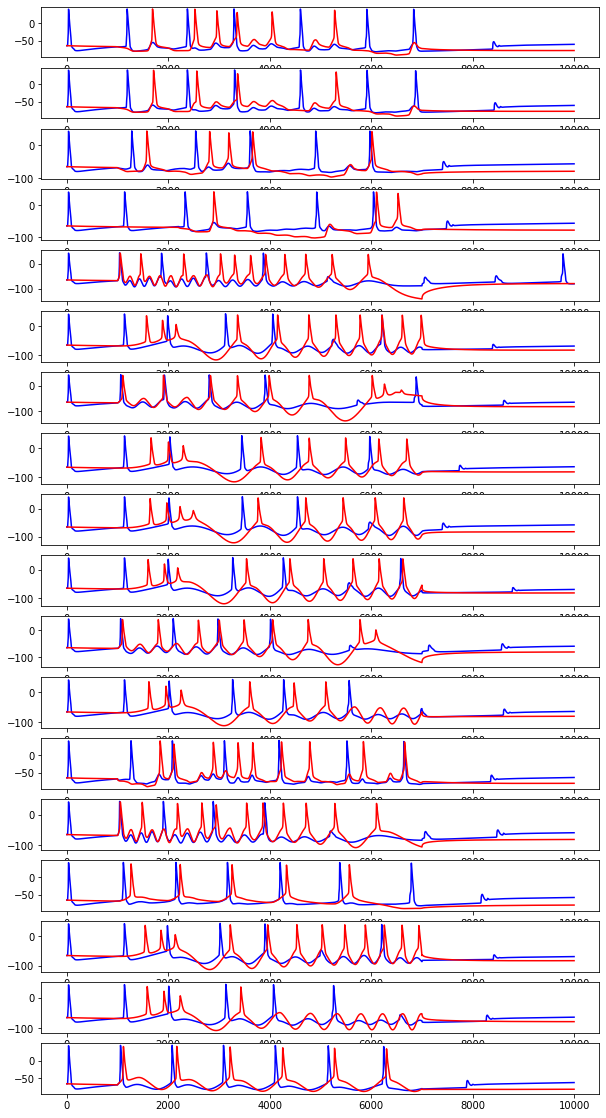

In [32]:
volts =  np.genfromtxt("best_ind.csv", delimiter=",")
targV = np.genfromtxt("/global/cscratch1/sd/zladd/axonstandardized/playground/gen_alg_GPU/Data/target_volts_BBP19.csv", delimiter=",")
fig, axs = plt.subplots(nrows=18,ncols=1,figsize=(10,20))
#fig.set_figheight(20)

for i in range(volts.shape[0]):
    axs[i].plot(volts[i], color="blue")
    axs[i].plot(targV[i], color="red")